# Gather insights from the experiments run on GCP

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from common.utils import check_missing_experiments, join_df
from common.metrics import *

## Define the TTA Formula 

In [2]:
# Calculate time to accuracy for different accuracies
def tta_crossbow(acc:int, df: pd.DataFrame, acc_column='accuracy', time_column='epoch_duration'):
    """Computes the tta as in the crossbow paper
    where the tta is the median of the last 5 epochs"""

    res = []
    for _, row in df.iterrows():
        done = False
        dur, accuracy = row[time_column], row[acc_column]
        
        for idx, (t, a) in enumerate(zip(dur, accuracy[:len(dur)])):
            
            # if there are less than 5 elements behind, continue
            if idx < 4:
                continue
                
            # calculate the median of the next five elements
            if np.median(accuracy[idx - 4:idx+1]) >= acc:
                res.append(t)
                done = True
                break

        if not done:
            res.append(np.nan)

    return res


def tta(acc:int, df:pd.DataFrame,  acc_column='accuracy', time_column='epoch_duration'):
    
    
    res = []
    for _, row in df.iterrows():
        done=False
        dur, accuracy = row[time_column], row[acc_column]
        
        for idx, (t, a) in enumerate(zip(dur, accuracy[:len(dur)])):
         
            if a >= acc:
                res.append(t)
                done = True
                break

        if not done:
            res.append(np.nan)

    return res
        

# KubeML Experiments

How to treat the kubeml experiments

### Load the train results

In [3]:
df = join_df('./results/resnet/train')
df = df[df.default_parallelism > 1]

In [6]:
df

,id,hash,model_type,batch_size,epochs,dataset,lr,function_name,default_parallelism,static_parallelism,validate_every,k,goal_accuracy,validation_loss,accuracy,train_loss,parallelism,epoch_duration
0,0386935d,69979e67b7622197,example,128,30,cifar10,0.1,resnet,4,True,1,8,100,"[2.0691979338851154, 1.761023279986804, 1.5237...","[21.41020569620253, 32.070806962025316, 47.784...","[3.4358344075022913, 1.9820176490715573, 1.680...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[46.101114115, 92.594095861, 138.901519929, 18..."
1,05666e5d,a2cc2a5d5cc402f9,example,128,30,cifar10,0.1,resnet,4,True,1,32,100,"[2.1832512511482722, 1.6482713418670847, 1.520...","[20.352056962025316, 39.47784810126582, 45.203...","[3.633183332122102, 1.9733640703619744, 1.6998...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[19.251981886, 39.583568774, 60.468725951, 79...."
2,06804c15,8b0f4cc587901704,example,256,30,cifar10,0.1,resnet,4,True,1,8,100,"[2.592677044868469, 1.7636539191007614, 1.6012...","[17.958984375, 33.1640625, 39.794921875, 44.40...","[4.071233475694851, 2.1830299715606536, 1.8489...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[26.678817886, 53.53629918, 78.251857194, 103...."
3,0bb3e9ac,50f218a144063794,example,64,30,cifar10,0.1,resnet,2,True,1,8,100,"[2.01867682842692, 1.906603324944806, 1.419383...","[28.54299363057325, 28.61265923566879, 47.2730...","[2.624373005631635, 1.756249717129466, 1.54868...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[102.032926309, 201.191873608, 299.563335538, ..."
4,13190b0b,02b1f56c9c27a5b4,example,128,30,cifar10,0.1,resnet,2,True,1,32,100,"[5.0395004236245455, 1.5423524047754988, 1.449...","[10.116693037974683, 44.11590189873418, 47.567...","[2.962399608322552, 1.6866237937795874, 1.4655...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[23.07288706, 46.800417874, 74.283571081, 98.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,f86d546d,4cf9aff8b0e3ec9e,example,64,30,cifar10,0.1,resnet,4,True,1,-1,100,"[3.8288797876637455, 2.403817397014351, 1.9774...","[10, 10.26, 26.85, 35.03, 40.550000000000004, ...","[3.360841138029304, 2.3875012396939574, 1.9948...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[14.801709896, 31.24002004, 48.253630979, 64.1..."
98,f9dc984a,9c49eeb8a706275a,example,64,30,cifar10,0.1,resnet,2,True,1,32,100,"[1.705808477037272, 1.4686595649476264, 1.3200...","[37.430334394904456, 46.34753184713376, 52.478...","[2.712390104218212, 1.6115226571822105, 1.4244...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[38.899608234, 82.870589755, 126.082686868, 16..."
99,f9ff89fc,7e945a487feff74e,example,128,30,cifar10,0.1,resnet,4,True,1,16,100,"[2.1471189894253695, 1.759268745591369, 1.5828...","[22.34, 33.46, 41.81, 47.64, 48.33999999999999...","[3.2209879354174644, 1.9946543223091535, 1.743...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[27.999510971, 57.792588364, 86.948315407, 115..."
100,fbcccc6c,afe503f94d4d8264,example,64,30,cifar10,0.1,resnet,4,True,1,32,100,"[1.8421584147556571, 1.573136512640935, 1.5360...","[31.22014331210191, 41.49084394904459, 42.8841...","[3.297370414573881, 1.8065422634400665, 1.6034...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[31.308027951, 61.831227029, 90.963939092, 120..."


In [ ]:
# get duplicated rows
df[df.duplicated(['hash'], keep=False)]

Define the extra variables

In [4]:
# Set the acc to the final accuracy
df['acc'] = df.accuracy.map(lambda a: a[-1])

# Set the time to the sum of the epoch durations
df['time'] = df.epoch_duration.map(lambda t: t[-1])

# Set the parallelism to the first since it is constant
df.parallelism = df.parallelism.map(lambda l:l[0])

# change -1 to inf so the order is right in the plot
df.k = df.k.map(lambda val: float('inf') if val == -1 else val)

df['global_batch'] = df.batch_size * df.parallelism




In [5]:
# compute the ttas
df['tta_69'] = tta(69, df)
df['tta_cross_69'] = tta_crossbow(69, df)

# compute the ttas
df['tta_67'] = tta(67, df)
df['tta_cross_67'] = tta_crossbow(67, df)

# compute the ttas
df['tta_70'] = tta(70, df)
df['tta_cross_70'] = tta_crossbow(70, df)

### For the metrics in resnet

In [7]:
metrics = join_df('./results/resnet/metrics')
m = metrics.rename(columns={'exp_name':'id'})

### For the metrics in the lenet

The first replication does not have the proper format, so we need to reformat it and combine it with the train results

In [ ]:
metrics1 = join_df('./results/lenet/metrics/1/')
metrics2 = join_df('./results/lenet/metrics/2/')
metrics3 = join_df('./results/lenet/metrics/3/')

cpu = metrics1.groupby('exp_name')['cpu'].apply(list)
mem = metrics1.groupby('exp_name')['mem'].apply(list)
exps = metrics1.groupby('exp_name')['exp_name']

metrics1 = pd.DataFrame({
    'cpu':cpu,
    'mem':mem
})
metrics1['exp_name'] = metrics1.index

# concat all metrics and rename the exp_name as in the train
m = pd.concat([metrics1, metrics2, metrics3], ignore_index=True)
m.rename(columns={'exp_name':'id'}, inplace=True)


Now we need to add extra summary columns to the metrics

In [8]:
# functions to compute the mean of each and add columns
m['mem'] = m['mem'].map(lambda l: l[0] if isinstance(l[0], list) else l)
m['cpu'] = m['cpu'].map(lambda l: l[0] if isinstance(l[0], list) else l)

# cpu util
m['cpu_mean'] = m['cpu'].map(lambda l: np.mean([s.percent for s in l]))

# gpu mean mem and util
m['gpu_0_mean_usage'] = m['gpu_0'].map(lambda l: np.mean([s.load for s in l if s.mem_used != 0]) if not isinstance(l, float) else l)
m['gpu_1_mean_usage'] = m['gpu_1'].map(lambda l: np.mean([s.load for s in l if s.mem_used !=0]) if not isinstance(l, float) else l)
m['gpu_0_mean_memory'] = m['gpu_0'].map(lambda l: np.mean([s.mem_used for s in l if s.mem_used != 0])if not isinstance(l, float) else l)
m['gpu_1_mean_memory'] = m['gpu_1'].map(lambda l: np.mean([s.mem_used for s in l if s.mem_used != 0])if not isinstance(l, float) else l)
m['gpu_usage'] = (m['gpu_0_mean_usage'] + m['gpu_1_mean_usage']) /2

# memory mean util
m['mem_mean'] = m['mem'].map(lambda l: np.mean([s.percent for s in l]))

#### Combine and Save the whole experiment

In [17]:
d = df.merge(m, on='id')
d.to_pickle('./dataframes/resnet_kubeml.pkl')


# TensorFlow Experiments

How to treat the TF experiments

In [9]:
folder = 'resnet_new'
df = join_df(f'./results/tf/{folder}/train/1/', f'./results/tf/{folder}/train/2', f'./results/tf/{folder}/train/3')

# Set the acc to the final accuracy
df['acc'] = df.val_accuracy.map(lambda a: a[-1])

# Set the time to the sum of the epoch durations
df['time'] = df.times.map(lambda t: t[-1])



In [13]:
# Define the TTA
df['tta_67'] = tta(0.67, df, time_column='times', acc_column='val_accuracy')
df['tta_cross_67'] = tta_crossbow(0.67, df, time_column='times', acc_column='val_accuracy')

df['tta_69'] = tta(0.69, df, time_column='times', acc_column='val_accuracy')
df['tta_cross_69'] = tta_crossbow(0.69, df, time_column='times', acc_column='val_accuracy')

df['tta_70'] = tta(0.70, df, time_column='times', acc_column='val_accuracy')
df['tta_cross_70'] = tta_crossbow(0.70, df, time_column='times', acc_column='val_accuracy')


## Merge the metrics from different  folders


In [16]:
m = join_df(f'./results/tf/{folder}/metrics/1/', f'./results/tf/{folder}/metrics/2', f'./results/tf/{folder}/metrics/3')

In [17]:
# functions to compute the mean of each and add columns
m['mem'] = m['mem'].map(lambda l: l[0] if isinstance(l[0], list) else l)
m['cpu'] = m['cpu'].map(lambda l: l[0] if isinstance(l[0], list) else l)

# cpu util
m['cpu_mean'] = m['cpu'].map(lambda l: np.mean([s.percent for s in l]))

# gpu mean mem and util
m['gpu_0_mean_usage'] = m['gpu_0'].map(lambda l: np.mean([s.load for s in l if s.mem_used != 0]) if not isinstance(l, float) else l)
m['gpu_1_mean_usage'] = m['gpu_1'].map(lambda l: np.mean([s.load for s in l if s.mem_used !=0]) if not isinstance(l, float) else l)
m['gpu_0_mean_memory'] = m['gpu_0'].map(lambda l: np.mean([s.mem_used for s in l if s.mem_used != 0])if not isinstance(l, float) else l)
m['gpu_1_mean_memory'] = m['gpu_1'].map(lambda l: np.mean([s.mem_used for s in l if s.mem_used != 0])if not isinstance(l, float) else l)
m['gpu_usage'] = (m['gpu_0_mean_usage'] + m['gpu_1_mean_usage']) /2

# memory mean util
m['mem_mean'] = m['mem'].map(lambda l: np.mean([s.percent for s in l]))

Join on the index

In [18]:
df = df.join(m)

Save the experiments

In [19]:
df.to_pickle('./dataframes/resnet_new_tensorflow.pkl')

# Visualization of Results


Set the color palette

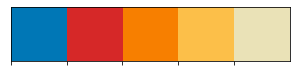

In [20]:
green_red_palette = ['#264653', '#2A9D8F', '#E9C46A', '#F4A261', '#E76F51']
blue_yellow_palette=  ['#0077b6', '#d62828', '#f77f00', '#fcbf49', '#eae2b7']
cool_p = ['#f87575', '#ffa9a3', '#b9e6ff', '#5c95ff', '#7e6c6c']
wall_p = ['#e63946', '#f1faee', '#a8dadc', '#457b9d', '#1d3557']

sns.palplot(sns.color_palette(blue_yellow_palette))


sns.set_theme(style='whitegrid', palette=blue_yellow_palette, )
sns.set_context('talk')
# sns.set_palette(blue_yellow_palette)

# Read the experiments file

### Load all of the dataframes

In [33]:
# load the tf experiments
resnet = pd.read_pickle('./dataframes/resnet_new_tensorflow.pkl')
lenet = pd.read_pickle('./dataframes/lenet_tensorflow.pkl')

lenet.rename(columns={
    'loss':'train_loss',
    'val_accuracy':'accuracy',
    'val_loss':'validation_loss',
    'times':'epoch_duration',
    'accuracy':'train_accuracy',
    'val_accuracy':'accuracy'
}, inplace=True)
lenet['system'] = 'tensorflow'
lenet['acc'] = 100*lenet['acc']
lenet['accuracy'] = lenet['accuracy'].map(lambda l: [100*n for n in l])

# rename columns in the TF dataframes to adhere to the kubeml ones
resnet.rename(columns={
    'loss':'train_loss',
    'val_accuracy':'accuracy',
    'val_loss':'validation_loss',
    'times':'epoch_duration',
    'accuracy':'train_accuracy',
    'val_accuracy':'accuracy'
}, inplace=True)
resnet['system'] = 'tensorflow'
resnet['acc'] = 100*resnet['acc']
resnet['accuracy'] = resnet['accuracy'].map(lambda l: [100*n for n in l])


# set the columns of the 

# load the kubeml experiments
kuberesnet = pd.read_pickle('./dataframes/resnet_kubeml.pkl')
kuberesnet['model'] = 'resnet'
kuberesnet['system'] = 'kubeml'
# kuberesnet['tta_70'] = tta(70, kuberesnet)
# kuberesnet['tta_cross_70'] = tta_crossbow(70, kuberesnet)

kubelenet = pd.read_pickle('./dataframes/lenet_kubeml.pkl')
kubelenet['model'] = 'lenet'
kubelenet['system'] = 'kubeml'


In [37]:
# save the full resnet stuff
r.to_pickle('./dataframes/resnet_new.pkl')

In [34]:
r = pd.concat([resnet, kuberesnet], ignore_index=True)
r
# resnet

,model,hash,batch_size,epochs,train_loss,train_accuracy,validation_loss,accuracy,epoch_duration,acc,...,dataset,lr,function_name,default_parallelism,static_parallelism,validate_every,k,goal_accuracy,parallelism,global_batch
0,resnet,44d99b585ec15030,32,70,"[2.440882444381714, 1.9447448253631592, 1.7837...","[0.17066000401973724, 0.26809999346733093, 0.3...","[2.0373032093048096, 1.7875392436981201, 1.791...","[21.709999442100525, 31.139999628067017, 38.22...","[90.5465760231018, 167.67973113059998, 243.727...",70.819998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,resnet,5d4210e3130a9739,128,70,"[2.7905611991882324, 1.7551709413528442, 1.588...","[0.20681999623775482, 0.3425599932670593, 0.42...","[1.957597017288208, 1.6984312534332275, 1.5086...","[25.65999925136566, 36.8800014257431, 44.74999...","[34.91643500328064, 55.42659902572632, 75.9164...",68.580002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,resnet,897dac71b62ec136,256,70,"[2.588197708129883, 1.6263797283172607, 1.4347...","[0.283160001039505, 0.4254800081253052, 0.4895...","[2.97422456741333, 1.4934394359588623, 1.49471...","[25.940001010894775, 46.11999988555908, 47.929...","[28.42989730834961, 40.05997085571289, 51.5759...",69.830000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,resnet,ad67202e9061c34e,64,70,"[2.3951144218444824, 1.7598485946655273, 1.599...","[0.2266400009393692, 0.35763999819755554, 0.42...","[1.9135148525238037, 1.7065120935440063, 1.471...","[27.559998631477356, 36.410000920295715, 47.04...","[53.67754888534546, 92.38472270965576, 131.467...",70.789999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,resnet,44d99b585ec15030,32,70,"[2.3818185329437256, 1.8773642778396606, 1.776...","[0.18386000394821167, 0.2983599901199341, 0.36...","[1.942749261856079, 1.838205099105835, 1.63964...","[26.53000056743622, 34.56999957561493, 43.0400...","[96.54499387741089, 177.19756150245667, 256.99...",71.450001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,resnet,4cf9aff8b0e3ec9e,64,30,"[3.360841138029304, 2.3875012396939574, 1.9948...",NaN,"[3.8288797876637455, 2.403817397014351, 1.9774...","[10, 10.26, 26.85, 35.03, 40.550000000000004, ...","[14.801709896, 31.24002004, 48.253630979, 64.1...",72.910000,...,cifar10,0.1,resnet,4.0,True,1.0,inf,100.0,4.0,256.0
104,resnet,9c49eeb8a706275a,64,30,"[2.712390104218212, 1.6115226571822105, 1.4244...",NaN,"[1.705808477037272, 1.4686595649476264, 1.3200...","[37.430334394904456, 46.34753184713376, 52.478...","[38.899608234, 82.870589755, 126.082686868, 16...",69.725318,...,cifar10,0.1,resnet,2.0,True,1.0,32.0,100.0,2.0,128.0
105,resnet,7e945a487feff74e,128,30,"[3.2209879354174644, 1.9946543223091535, 1.743...",NaN,"[2.1471189894253695, 1.759268745591369, 1.5828...","[22.34, 33.46, 41.81, 47.64, 48.33999999999999...","[27.999510971, 57.792588364, 86.948315407, 115...",67.620000,...,cifar10,0.1,resnet,4.0,True,1.0,16.0,100.0,4.0,512.0
106,resnet,afe503f94d4d8264,64,30,"[3.297370414573881, 1.8065422634400665, 1.6034...",NaN,"[1.8421584147556571, 1.573136512640935, 1.5360...","[31.22014331210191, 41.49084394904459, 42.8841...","[31.308027951, 61.831227029, 90.963939092, 120...",70.989252,...,cifar10,0.1,resnet,4.0,True,1.0,32.0,100.0,4.0,256.0


### Create new columns for representation

- Final accuracy
- Total time taken
- Parallelism

### Plot the Correlations between the K, Batch and Parallelism with time and accuracy

In [ ]:
corr = df[['k', 'batch_size', 'parallelism', 'acc', 'time']].corr()
sns.heatmap(corr,
            annot=True,
)

# plt.savefig('./figures/resnet34/heat.png', dpi=300)


In [ ]:
df.sort_values('time')

mean = df.groupby('hash').mean()

### Get the max accuracies and times and check the parameters used

In [ ]:
# get the max accuracies
df[['k', 'parallelism', 'acc','batch_size','time']].sort_values(by='time', ascending=True)

## Calculate TTA with different accuracies



In [ ]:
s = df.sort_values('tta_cross_99')[['k', 'batch_size', 'parallelism', 'tta_cross_99', 'tta_99', 'acc', 'accuracy', 'epoch_duration']]

# plot the best
best = s.iloc[0]
best


x = range(1, len(best.accuracy)+1)
plt.figure()
plt.title(f'Best tta_99 (B={best.batch_size}, k={best.k}, P={best.parallelism})')
sns.lineplot(x=best.epoch_duration, y = best.accuracy)
sns.lineplot(x=best.epoch_duration, y= 99)
plt.scatter(best.tta_cross_99, 99, marker='X', s=60, c='r')
plt.xlabel('Time (s)', fontsize=15)
plt.ylabel('Accuracy (%)', fontsize=15)

# plt.savefig('./figures/gpu/best.png', dpi=300)


# Plot the resnet results KubeML vs Tensorflow

In [99]:
#Define the colors used
tf_color = '#FF6F00'
kubecolor = '#316CE6'



## LeNet Results

In [129]:
l = pd.read_pickle('./dataframes/lenet.pkl')

### Plot the Accuracy and Train Loss Progression

Text(0.5, 0, 'Time (sec)')

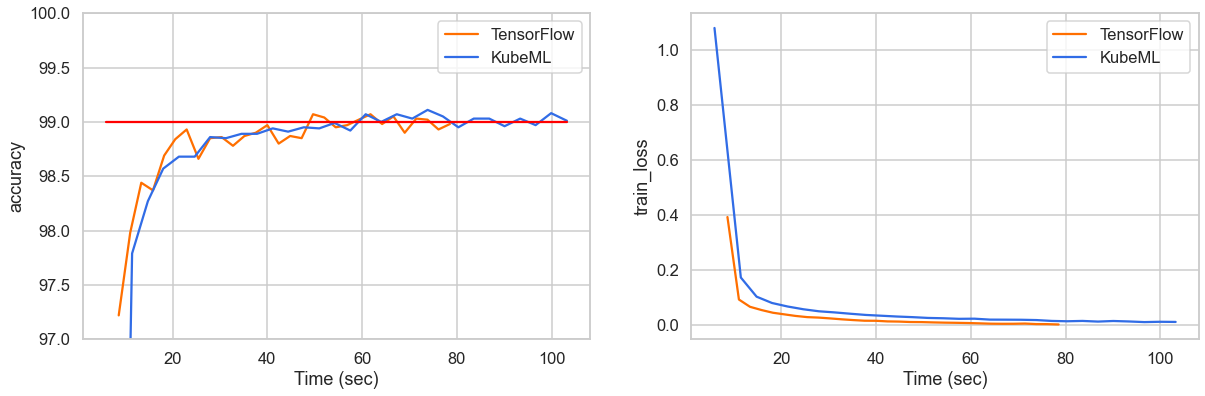

In [143]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(20, 6))

# get the best results
tf = l[l.system=='tensorflow']
ml = l[l.system =='kubeml']
sample = tf.iloc[5]
kubesample = ml.iloc[87]

# sort for tta69 and show

# 1) plot the validation accuracy of TF
sns.lineplot(x=sample.epoch_duration[:30],
             y=sample.accuracy[:30],
             data=sample, 
            ax=ax1, 
            label='TensorFlow',
            color='#FF6F00')

# 2) plot the validation accuracy of KubeML
sns.lineplot(x=kubesample.epoch_duration,
             y='accuracy',
             data=kubesample, 
            ax=ax1, 
            label='KubeML',
            color='#316CE6')

ax1.set_ylim([97, 100])
ax1.set_xlabel('Time (sec)')



# plot the line at 69%
sns.lineplot(x=kubesample.epoch_duration,
            y=99,
            ax=ax1,
            color='red')

# 3) Plot the train loss
sns.lineplot(x=sample.epoch_duration[:30],
             y=sample.train_loss[:30],
             data=sample, 
            ax=ax2, 
            label='TensorFlow',
            color='#FF6F00')

# 3) Plot the train loss
sns.lineplot(x=kubesample.epoch_duration,
             y='train_loss',
             data=kubesample, 
            ax=ax2, 
            label='KubeML',
            color='#316CE6')

ax2.set_xlabel('Time (sec)')

### Plot the whole comparison

c:\users\diego\cs\qpe\venv\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


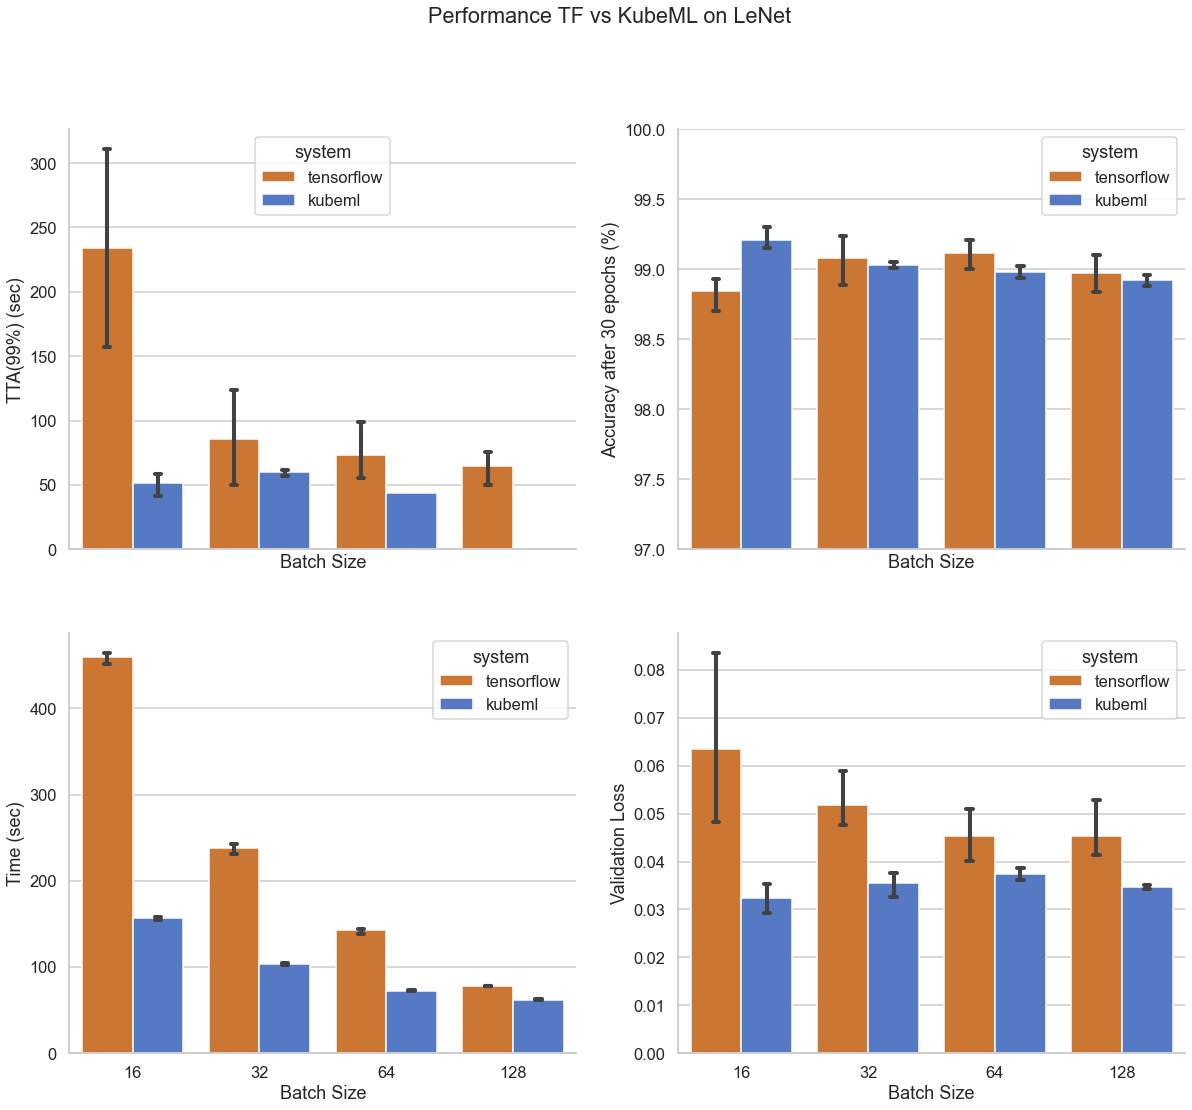

In [140]:
# get only the results with k=-1 and 
_l = l[((l.parallelism==4) | (l.parallelism.isna())) & ((l.k==float('inf')) | (l.k.isna())) ]

# set the palette
sns.set_palette([tf_color, kubecolor], desat=0.8)


# COMPARE THE LOSSES, THE VAL LOSS OF KUBEML SHOULD BE HIGHER (DO NOT KNOW THE TRAIN LOSS, BECAUSE OF EXPLORATION,
# WHILE STILL GIVING BEST ACCURACY (BETTER GENERALIZATION))
f, ax = plt.subplots(2, 2, sharex=True, figsize=(20, 17))

# 1) Plot the comparison of tta between both
sns.barplot(x='batch_size', 
            y='tta_99', 
            data=_l, 
            hue='system',
            capsize=.05,
            ax=ax[0][0])
ax[0][0].set_xlabel('Batch Size')
ax[0][0].set_ylabel('TTA(99%) (sec)')


# 2) Plot the max accuracy
sns.barplot(x='batch_size', 
            y='acc', 
            data=_l, 
            hue='system', 
            capsize=.05,
            ax=ax[0][1])
ax[0][1].set_ylim([97, 100])
ax[0][1].set_xlabel('Batch Size')
ax[0][1].set_ylabel('Accuracy after 30 epochs (%)')


# 3) Plot the difference in GPU utilzation
sns.barplot(x='batch_size', 
            y='time', 
            data=_l, 
            hue='system', 
            capsize=.05,
            ax=ax[1][0])
ax[1][0].set_xlabel('Batch Size')
ax[1][0].set_ylabel('Time (sec)')


# 4) Plot the val loss of both compared
# calculate the loss
_l['loss'] = _l['validation_loss'].map(lambda l:l[-1])
sns.barplot(x='batch_size', 
            y='loss', 
            data=_l ,
            capsize=.05,
            hue='system',
            ax=ax[1][1])

ax[1][1].set_xlabel('Batch Size')
ax[1][1].set_ylabel('Validation Loss')

plt.suptitle('Performance TF vs KubeML on LeNet')


sns.despine()

plt.savefig('./figures/ppt/lenet-performance.png', dpi=400)

### Comparison of accuracy and time between K

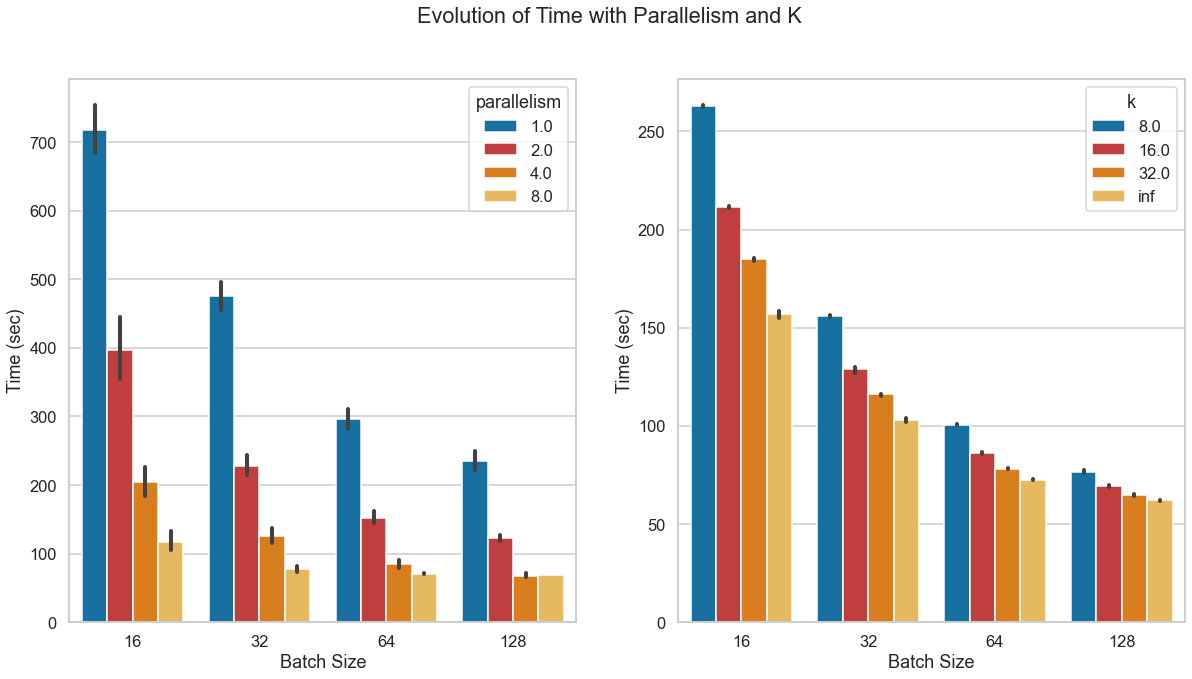

In [157]:
f, ax = plt.subplots(1, 2, sharex=True, figsize=(20, 10))



_kubelenet = l[(l.system == 'kubeml')]
# 1) plot the accuracy reached with different k
sns.barplot(x='batch_size',
           y='time',
           data=_kubelenet, 
           hue='parallelism',
           ax=ax[0])
ax[0].set_xlabel('Batch Size')
ax[0].set_ylabel('Time (sec)')


_kubelenet = l[(l.system == 'kubeml') & (l.parallelism==4)]
# 2) plot the time reached with different k
sns.barplot(x='batch_size',
           y='time',
           data=_kubelenet, 
           hue='k',
           ax=ax[1])
ax[1].set_xlabel('Batch Size')
ax[1].set_ylabel('Time (sec)')

plt.suptitle('Evolution of Time with Parallelism and K')

plt.savefig('./figures/ppt/lenet-time.png', dpi=400)

## Tensorflow Results

#### Plot the Train Loss and Val Accuracy of Tensorflow and KubeML


In [122]:
# set the palette
sns.set_palette([tf_color, kubecolor], desat=0.8)

In [124]:
r = pd.read_pickle('./dataframes/resnet_new.pkl')

In [152]:
r[(r.batch_size==32) & (r.system=='kubeml') & (r.k == float('inf')) & (r.parallelism ==4)]['time']

32    667.208321
77    661.598233
90    652.228196
Name: time, dtype: float64

<AxesSubplot:ylabel='train_loss'>

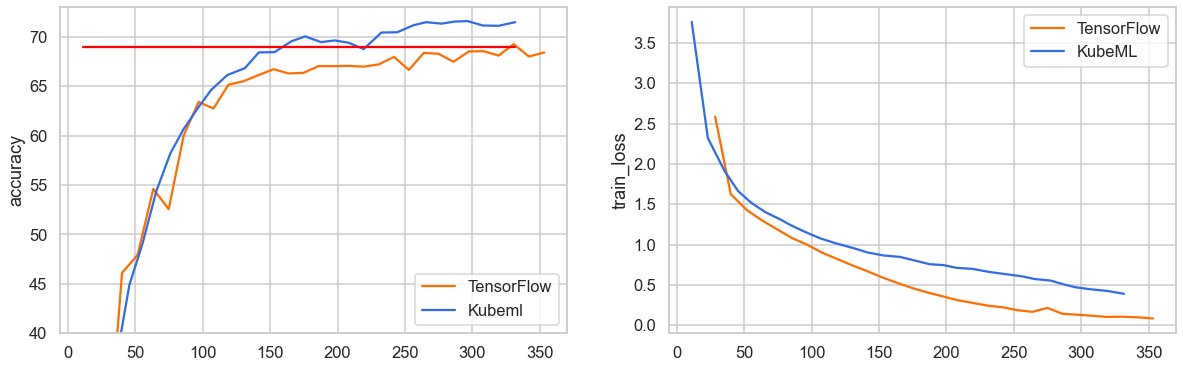

In [148]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(20, 6))

# get the best results
tf = r[r.system=='tensorflow']
ml = r[r.system =='kubeml']
sample = r.iloc[2]
kubesample = r.iloc[61]

# sort for tta69 and show

# 1) plot the validation accuracy of TF
sns.lineplot(x=sample.epoch_duration[:30],
             y=sample.accuracy[:30],
             data=sample, 
            ax=ax1, 
            label='TensorFlow',
            color='#FF6F00')

# 2) plot the validation accuracy of KubeML
sns.lineplot(x=kubesample.epoch_duration,
             y='accuracy',
             data=kubesample, 
            ax=ax1, 
            label='Kubeml',
            color='#316CE6')

ax1.set_ylim([40, 73])



# plot the line at 69%
sns.lineplot(x=kubesample.epoch_duration,
            y=69,
            ax=ax1,
            color='red')

# 3) Plot the train loss
sns.lineplot(x=sample.epoch_duration[:30],
             y=sample.train_loss[:30],
             data=sample, 
            ax=ax2, 
            label='TensorFlow',
            color='#FF6F00')

# 3) Plot the train loss
sns.lineplot(x=kubesample.epoch_duration,
             y='train_loss',
             data=kubesample, 
            ax=ax2, 
            label='KubeML',
            color='#316CE6')


### Plot the metrics of both 

c:\users\diego\cs\qpe\venv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\diego\cs\qpe\venv\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\diego\cs\qpe\venv\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

Text(0.5, 0.98, 'Performance TF vs KubeML on Resnet34')

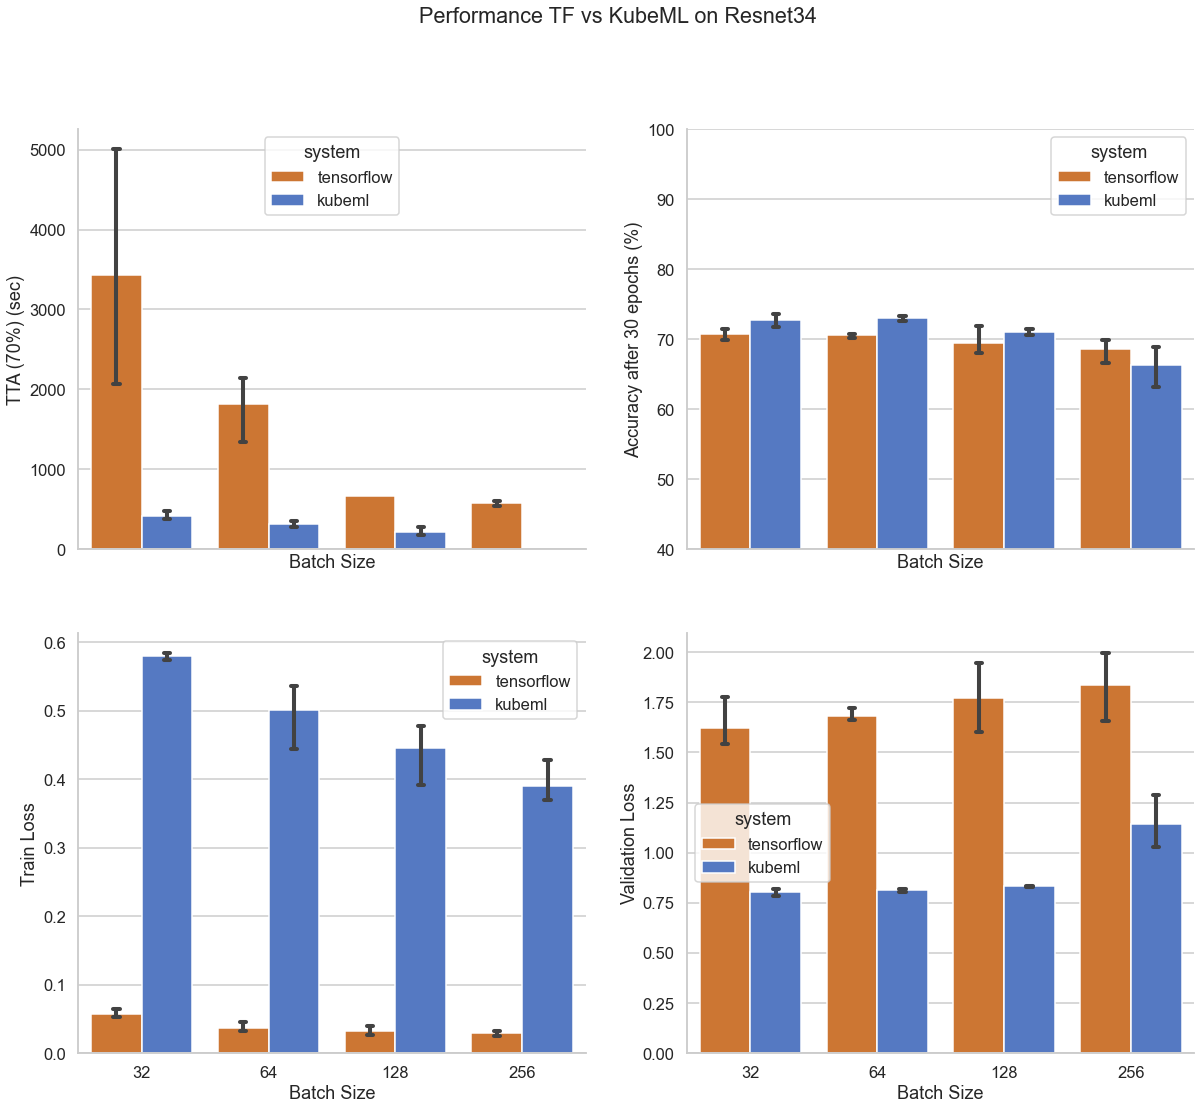

In [126]:
# get only the results with k=-1 and 
_r = r[((r.parallelism==4) | (r.parallelism.isna())) & ((r.k==float('inf')) | (r.k.isna())) ]
_r['t30'] = _r['time']


# COMPARE THE LOSSES, THE VAL LOSS OF KUBEML SHOULD BE HIGHER (DO NOT KNOW THE TRAIN LOSS, BECAUSE OF EXPLORATION,
# WHILE STILL GIVING BEST ACCURACY (BETTER GENERALIZATION))
f, ax = plt.subplots(2, 2, sharex=True, figsize=(20, 17))

# 1) Plot the comparison of tta between both
sns.barplot(x='batch_size', 
            y='tta_70', 
            data=_r, 
            hue='system', 
            ax=ax[0][0],
           capsize=.05)
ax[0][0].set_xlabel('Batch Size')
ax[0][0].set_ylabel('TTA (70%) (sec)')


# 2) Plot the max accuracy
sns.barplot(x='batch_size', 
            y='acc', 
            data=_r, 
            hue='system', 
            ax=ax[0][1],
            capsize=.05)
ax[0][1].set_ylim([40, 100])
ax[0][1].set_xlabel('Batch Size')
ax[0][1].set_ylabel('Accuracy after 30 epochs (%)')


# 3) Plot the difference in GPU utilzation
_r['t_loss'] = _r['train_loss'].map(lambda l:l[-1])
sns.barplot(x='batch_size', 
            y='t_loss', 
            data=_r, 
            hue='system', 
            ax=ax[1][0],
            capsize=.05,
               )
ax[1][0].set_xlabel('Batch Size')
ax[1][0].set_ylabel('Train Loss')


# 4) Plot the val loss of both compared
# calculate the loss
_r['loss'] = _r['validation_loss'].map(lambda l:l[-1])
sns.barplot(x='batch_size', 
            y='loss', 
            data=_r ,
            hue='system',
            ax=ax[1][1],
            capsize=.05)

ax[1][1].set_xlabel('Batch Size')
ax[1][1].set_ylabel('Validation Loss')


sns.despine()
plt.suptitle('Performance TF vs KubeML on Resnet34')

# plt.savefig('./figures/ppt/resnet-performance.png', dpi=400)


### Comparison of Time with Parallelism and K

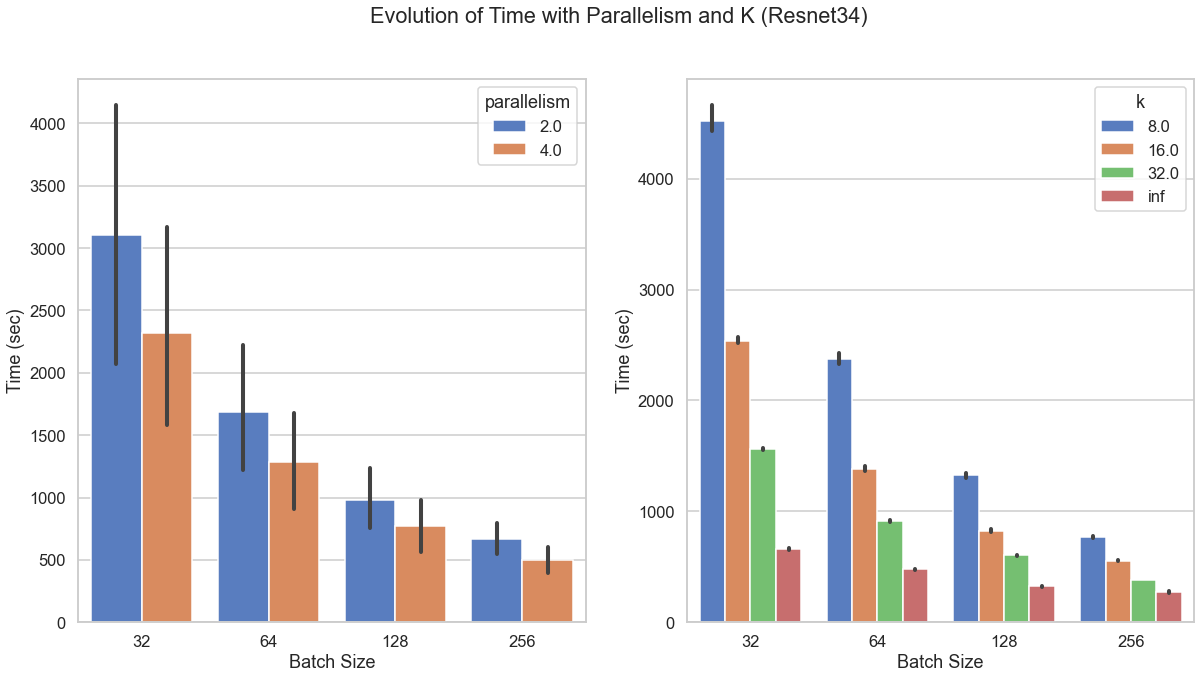

In [127]:
f, ax = plt.subplots(1, 2, sharex=True, figsize=(20, 10))

sns.set_palette('muted',10)

_kuberesnet = r[(r.system == 'kubeml')]
# 1) plot the accuracy reached with different k
sns.barplot(x='batch_size',
           y='time',
           data=_kuberesnet, 
           hue='parallelism',
           ax=ax[0])
ax[0].set_xlabel('Batch Size')
ax[0].set_ylabel('Time (sec)')


_kuberesnet = r[(r.system == 'kubeml') & (r.parallelism==4)]
# 2) plot the time reached with different k
sns.barplot(x='batch_size',
           y='time',
           data=_kuberesnet, 
           hue='k',
           ax=ax[1])
ax[1].set_xlabel('Batch Size')
ax[1].set_ylabel('Time (sec)')

plt.suptitle('Evolution of Time with Parallelism and K (Resnet34)')

plt.savefig('./figures/ppt/resnet-time.png', dpi=400)

In [128]:
g = _r.loc[(_r.batch_size==32) & (_r.system=='kubeml')]
for a, t in zip(g.iloc[0].accuracy, g.iloc[0].epoch_duration):
    print(t, a)

20.428196244 9.984025559105431
40.319779652 9.984025559105431
61.686889996 14.626597444089457
86.365460488 36.42172523961661
107.288615526 44.269169329073485
127.143355572 48.33266773162939
147.370523872 51.61741214057508
171.896117842 54.56269968051118
193.17200993 52.326277955271564
214.568396946 55.1517571884984
236.181015178 53.23482428115016
255.853514819 57.418130990415335
277.395876674 64.1473642172524
297.280543545 65.08586261980831
321.930950711 67.62180511182109
347.36463734 68.04113418530352
372.712361303 70.18769968051119
398.098658065 70.13777955271566
423.928867715 70.5870607028754
445.087157321 71.3258785942492
466.50902278 70.96645367412141
486.349852799 72.254392971246
507.840430352 72.40415335463258
532.615866273 71.89496805111821
554.122855911 72.77356230031948
575.332756226 72.6138178913738
596.392340379 73.03314696485623
616.266527002 73.64217252396166
641.224487936 73.19289137380191
667.208320632 73.57228434504792


## Do ANOVA Linear Model to calculate the influence of the parameters

Using ANOVA we can get an idea of how the different parameters interact with each other and their influence

In [ ]:
# For the ANOVA test
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [ ]:
def ANOVA(df: pd.DataFrame, y: str, use_all = False,verbose=False):
    """Run the ANOVA analysis with the batch, k and parallelism columns for the 
    given output variable"""
    
    # If use all is true we use all the variables to check either accuracy and time
    # including also the iowait and the cpu to see what fully influences the stuff
    
    
    if not use_all:
        # Plot the summary dataframe
        if verbose:
            display(rp.summary_cont(df.groupby(['batch_size', 'k', 'parallelism']))[y])

        model = ols(f'{y} ~ batch_size*k*parallelism', df).fit()
        
    else:
        if y not in ['acc', 'time']:
            raise ValueError('When use_all = True we predict either final_accuracy or time, not', y)
        if verbose:
            display(rp.summary_cont(df.groupby(['batch_size', 'k', 'parallelism']))[y])

        model = ols(f'{y} ~ cpu*batch*njobs*cpu_mean*iowait_mean', df).fit()
        

    if verbose:
        print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
        display(model.summary())
    
    res = sm.stats.anova_lm(model, typ=2)
    
    return res, model

In [ ]:
# df.k = df.k.map(lambda val: -1 if val == float('inf') else val)

res, model = ANOVA(d, y='gpu_usage', verbose=True)

res



### Plot the distributions of time and accuracy as a function of K, Batch and parallelism

#### Plot the accuracy as a factor

In [ ]:
plt.rc('font', size=16)

f, ax = plt.subplots(1, 3, sharey=True, figsize=(20, 5))
sns.barplot(x='batch_size', y='acc', hue='k', data=df, ax=ax[0], capsize=.05)
sns.barplot(x='k', y='acc', data=df, ax=ax[1], capsize=.05, hue='parallelism')
sns.barplot(x='parallelism', y='acc', data=df, hue='k' ,ax=ax[2] ,capsize=.05)
sns.despine()
plt.legend(title='k', ncol=4, bbox_to_anchor=(0.075,1))

for a in ax:
    a.set_ylim([75, 100])



# plt.savefig('./figures/resnet34/accuracy.png', dpi=300)

In [ ]:
plt.rc('font', size=16)
plt.figure(figsize=(15,10))
sns.barplot(x='parallelism', y='tta_cross_99', data=df, capsize=.02, hue='batch_size')


# plt.savefig('./figures/resnet34/acc_per_k_and_parallelism.png', dpi=300)

In [ ]:
df= pd.read_pickle('./dataframes/lenet_tensorflow.pkl')
d = pd.read_pickle('./dataframes/lenet_kubeml.pkl')
d = d.loc[d.parallelism==2]

In [ ]:
d.sort_values('tta_cross_99')[['batch_size', 'tta_cross_99']]

#### Plot the time as a factor

In [ ]:
f, ax = plt.subplots(1, 3, sharey=True, figsize=(20, 5))


sns.barplot(x='batch_size', 
            y='tta_cross_99', 
            data=d ,
            ax=ax[0],
            estimator=np.min)

sns.barplot(x='batch_size', y='tta_cross_99', data=df, ax=ax[1], estimator=np.min)
# sns.barplot(x='parallelism', y='time', data=df, ax=ax[2], hue='k')

# plt.savefig('./figures/resnet34/time.png', dpi=300)

In [ ]:
plt.rc('font', size=16)
f, ax = plt.subplots(1, 3, figsize=(20,8), sharey=True)
sns.barplot(x='k', y='time', data=df.loc[df.batch_size==32], capsize=.05, hue='parallelism', ax=ax[0])
sns.barplot(x='k', y='time', data=df.loc[df.batch_size==64], capsize=.05, hue='parallelism', ax=ax[1])
sns.barplot(x='k', y='time', data=df.loc[df.batch_size==128], capsize=.05, hue='parallelism', ax=ax[2])

plt.savefig('./figures/resnet34/time_per_all.png', dpi=300)

In [ ]:
# Plot the validation lines of k=-1 and batch = 32 with different parallelism
def plot_loss_with_k_and_batch(k: int, batch:int, ax: plt.Axes = None):
    d = df.loc[(df.k==k) & (df.batch_size==batch)].sort_values(by='parallelism', ascending=False)

    plt.rc('font', size=13)
    if ax is None:
        f = plt.figure(figsize=(10, 5))
        for _, row in d.iterrows():
#             print(row.accuracy)
            plt.plot(range(1,6), row.accuracy[:-1] if len(row.accuracy) == 6 else row.accuracy, label=str(row.parallelism))
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title(f'Accuracy evolution with LeNet (batch={batch}, k={k})')
        plt.legend(title='parallelism', bbox_to_anchor=(1.05, 0.8))
        
    else:
        for _, row in d.iterrows():
#             print(row.accuracy)
            ax.plot(range(1,6), row.accuracy[:-1] if len(row.accuracy) == 6 else row.accuracy, label=str(row.parallelism))
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy (%)')
        ax.set_title(f'Batch={batch}, k={k}')
        ax.legend(title='parallelism')
        

f, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15), sharex=True)

plt.suptitle('Behavior of K, Parallelism and Batch in Accuracy')

plot_loss_with_k_and_batch(k=8, batch=32, ax=axes[0][0])
plot_loss_with_k_and_batch(k=16, batch=32, ax=axes[0][1])   
plot_loss_with_k_and_batch(k=64, batch=32, ax=axes[0][2])
    
plot_loss_with_k_and_batch(k=8, batch=64, ax=axes[1][0])
plot_loss_with_k_and_batch(k=16, batch=64, ax=axes[1][1])   
plot_loss_with_k_and_batch(k=64, batch=64, ax=axes[1][2])

plot_loss_with_k_and_batch(k=8, batch=128, ax=axes[2][0])
plot_loss_with_k_and_batch(k=16, batch=128, ax=axes[2][1])   
plot_loss_with_k_and_batch(k=64, batch=128, ax=axes[2][2])


# plt.savefig('./figures/accuracy_study.png', dpi=300)


#### Keep K and Batch set, vary parallelism

In [ ]:
# Plot the validation lines of k=-1 and batch = 32 with different parallelism
def plot_loss_with_k_and_batch(k: int, batch:int, ax: plt.Axes = None):
    d = df.loc[(df.k==k) & (df.batch_size==batch)].sort_values(by='parallelism', ascending=False)

    plt.rc('font', size=13)
    if ax is None:
        f = plt.figure(figsize=(10, 5))
        for _, row in d.iterrows():
#             print(row.accuracy)
            plt.plot(range(1,6), row.accuracy[:-1] if len(row.accuracy) == 6 else row.accuracy, label=str(row.parallelism))
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title(f'Accuracy evolution with LeNet (batch={batch}, k={k})')
        plt.legend(title='parallelism', bbox_to_anchor=(1.05, 0.8))
        
    else:
        for _, row in d.iterrows():
#             print(row.accuracy)
            ax.plot(range(1,6), row.accuracy[:-1] if len(row.accuracy) == 6 else row.accuracy, label=str(row.parallelism))
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy (%)')
        ax.set_title(f'Batch={batch}, k={k}')
        ax.legend(title='parallelism')
        

f, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15), sharex=True)

plt.suptitle('Behavior of K, Parallelism and Batch in Accuracy')

plot_loss_with_k_and_batch(k=8, batch=32, ax=axes[0][0])
plot_loss_with_k_and_batch(k=16, batch=32, ax=axes[0][1])   
plot_loss_with_k_and_batch(k=64, batch=32, ax=axes[0][2])
    
plot_loss_with_k_and_batch(k=8, batch=64, ax=axes[1][0])
plot_loss_with_k_and_batch(k=16, batch=64, ax=axes[1][1])   
plot_loss_with_k_and_batch(k=64, batch=64, ax=axes[1][2])

plot_loss_with_k_and_batch(k=8, batch=128, ax=axes[2][0])
plot_loss_with_k_and_batch(k=16, batch=128, ax=axes[2][1])   
plot_loss_with_k_and_batch(k=64, batch=128, ax=axes[2][2])


# plt.savefig('./figures/accuracy_study.png', dpi=300)


#### Keep Parallelism and batch set, vary K

In [ ]:
# Plot the validation lines of k=-1 and batch = 32 with different parallelism
def plot_loss_with_parallelism_and_batch(p: int, batch:int, ax: plt.Axes = None):
    d = df.loc[(df.parallelism==p) & (df.batch_size==batch)].sort_values(by='k', ascending=False)
    
    approx_k = (60000/p)/batch

    plt.rc('font', size=16)
    if ax is None:
        f = plt.figure(figsize=(10, 5))
        for _, row in d.iterrows():
#             print(row.accuracy)
            plt.plot(range(1,6), row.accuracy[:-1] if len(row.accuracy) == 6 else row.accuracy, label=str(row.k))
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title(f'Accuracy evolution with LeNet (batch={batch}, k={k})')
        plt.legend(title='parallelism', bbox_to_anchor=(1.05, 0.8))
        
    else:
        for _, row in d.iterrows():
            label = str(row.k) if row.k != float('inf') else f'{row.k} ({int(approx_k)})'
            ax.plot(range(1,6), row.accuracy[:-1] if len(row.accuracy) == 6 else row.accuracy, label=label)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy (%)')
        ax.set_title(f'Batch={batch}, Parallelism={p}')
        ax.legend(title='k')
        

f, axes = plt.subplots(nrows=3, ncols=3, figsize=(30, 20), sharex=True)

plt.suptitle('Behavior of K, Parallelism and Batch in Accuracy')

plot_loss_with_parallelism_and_batch(p=2, batch=32, ax=axes[0][0])
plot_loss_with_parallelism_and_batch(p=4, batch=32, ax=axes[0][1])   
plot_loss_with_parallelism_and_batch(p=8, batch=32, ax=axes[0][2])

plot_loss_with_parallelism_and_batch(p=2, batch=64, ax=axes[1][0])
plot_loss_with_parallelism_and_batch(p=4, batch=64, ax=axes[1][1])   
plot_loss_with_parallelism_and_batch(p=8, batch=64, ax=axes[1][2])

plot_loss_with_parallelism_and_batch(p=2, batch=128, ax=axes[2][0])
plot_loss_with_parallelism_and_batch(p=4, batch=128, ax=axes[2][1])   
plot_loss_with_parallelism_and_batch(p=8, batch=128, ax=axes[2][2])


plt.savefig('./figures/accuracy_study_varying_k.png', dpi=300)

#### Plot 3d dependencies between K and parallelism on time and accuracy

In [ ]:
# f, ax = plt.subplots(1, 2, projection='3d')

f = plt.figure()
ax = f.add_subplot(1, 2, 1, projection='3d')

from scipy.interpolate import griddata
X, Y = np.meshgrid(df.k.map(lambda v: 500 if v == float('inf') else v), df.parallelism)
Z = griddata((df.k.map(lambda v: 500 if v == float('inf') else v),
              df.parallelism),
              df.acc, (X, Y), method='cubic')

ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='coolwarm',
                       linewidth=0, antialiased=False)


In [ ]:
d = df.loc[df.batch==64]